<a href="https://colab.research.google.com/github/aarondelgiudice/thinkful_data_bootcamp/blob/master/unit_7/capstone/7_1d_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering
### Table of Contents
- Import Data
  - Define Data and Target
  - Scale Data
- Clustering
  - Model Feature Sets
- Model Cluster Labels

Now that we have our clean and parsed lyric data and our bag-of-words features, we can model the lyrics. We'll model our lyrics with the audio features from Spotify to see if we can improve on our previous model's performance. And even though we have a clear target value, we'll employ both supervised and unsupervised methods for modeling our data. We can then compare the difference models performance with cross-validation and variance. Once we have selected the best model, we'll fine tune its performance using grid search. Finally, we'll analyze our audio data with our tuned model and see how accurately we can classify songs with both the audio features and lyric data.

## Import Data

In [0]:
# load packages
import numpy as np
import pandas as pd
# set random seed
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score, make_scorer

from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# change field size to avoid ParseError
import sys
import csv

#csv.field_size_limit(sys.maxsize)

filename = "spotify_lyrics_clean"
# set engine="python" to avoid ParseError
# set error_bad_lines=False
#df_lyrics = pd.read_csv(filename + ".csv", index_col=0,
#                        engine="python", error_bad_lines=False)
df_lyrics = pd.read_csv(filename + ".csv", index_col=0)
# make sure lyric data is type string
#df_lyrics['lyrics_raw'] = df_lyrics['lyrics_raw'].astype(str)
#df_lyrics['lyrics_clean'] = df_lyrics['lyrics_clean'].astype(str)
df_lyrics.reset_index(drop=True, inplace=True)
print(df_lyrics.shape)
print(df_lyrics.dropna().shape)
#df_lyrics = df_lyrics.dropna().sort_index()
df_lyrics.head()

(2990, 11)
(2990, 11)


,id,artist,track,lyrics_raw,length_raw,lyrics_clean,length_clean,lyrics_parsed,length_parsed,lyrics_nostops,length_nostops
0,7eElVgPcxDqmgGrSwVFI74,lorde,sober,"[Intro]\nNight, midnight, lose my mind\nNight,...",2485,night midnight lose my mind night midnight lo...,2275,"[' ', 'night', 'midnight', 'lose', '-PRON-', '...",494,"[' ', 'night', 'midnight', 'lose', 'mind', 'ni...",187
1,02oAUzv4M0ItuTDy2RT3IT,lorde,homemade dynamite,[Verse 1]\nA couple rebel top gun pilots\nFlyi...,1795,couple rebel top gun pilots flying with nowhe...,1621,"[' ', 'couple', 'rebel', 'top', 'gun', 'pilot'...",309,"[' ', 'couple', 'rebel', 'gun', 'pilot', 'fly'...",169
2,5q4BpnMrYEFzLO0dYODj6J,lorde,the louvre,"[Verse 1]\nWell, summer slipped us underneath ...",1824,well summer slipped us underneath her tongue ...,1665,"[' ', 'well', 'summer', 'slip', '-PRON-', 'und...",334,"[' ', 'summer', 'slip', 'underneath', 'tongue'...",151
3,6Kkt27YmFyIFrcX3QXFi2o,lorde,liability,"[Intro]\nOne, two\n\n[Verse 1]\nBaby really hu...",1305,one two baby really hurt me crying in the tax...,1157,"[' ', 'one', 'two', 'baby', 'really', 'hurt', ...",242,"[' ', 'baby', 'hurt', 'cry', 'taxi', 'don', 'w...",101
4,1Dp7JGFNjvg8Nk0CtMCcnr,lorde,hard feelings loveless,Hard Feelings\n\n(Go back and tell it)\n\nPlea...,2386,hard feelings go back and tell it please could...,2189,"['hard', 'feeling', 'go', 'back', 'and', 'tell...",458,"['hard', 'feeling', 'tell', 'tender', 'sit', '...",244


In [3]:
filename = "spotify_features"
Audio_features = pd.read_csv(filename + ".csv", index_col=0)

print(Audio_features.shape)
Audio_features.reset_index(drop=True, inplace=True)
print(Audio_features.dropna().shape)
Audio_features.head()

(2990, 18)
(2990, 18)


,id,target,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,year
0,7eElVgPcxDqmgGrSwVFI74,0,0.1730,0.796,197236,0.467,True,0.004110,6,0.1260,-10.369,1,59,0.1810,107.901,4,0.516,2017
1,02oAUzv4M0ItuTDy2RT3IT,0,0.2870,0.771,189796,0.431,True,0.000003,10,0.0934,-5.423,1,59,0.0577,107.047,4,0.268,2017
2,5q4BpnMrYEFzLO0dYODj6J,0,0.2390,0.664,271088,0.382,False,0.007490,0,0.0943,-9.977,1,61,0.0470,123.214,4,0.126,2017
3,6Kkt27YmFyIFrcX3QXFi2o,0,0.9200,0.587,171728,0.229,False,0.000000,10,0.1000,-11.254,0,69,0.1280,75.670,4,0.379,2017
4,1Dp7JGFNjvg8Nk0CtMCcnr,0,0.0328,0.487,367391,0.445,True,0.010400,1,0.0778,-10.959,0,60,0.1130,97.031,4,0.180,2017


In [5]:
filename = 'spotify_word_counts'
word_counts = pd.read_csv(filename+".csv", index_col=0)
word_counts.reset_index(inplace=True)
print(word_counts.shape)
print(word_counts.dropna().shape)
word_counts.head()

(2990, 1025)
(2990, 1025)


,id,m,know,don,love,oh,like,get,go,will,come,time,yeah,let,ve,to,feel,want,cause,baby,wanna,way,tell,think,ain,heart,good,,night,right,need,away,say,girl,look,little,win,leave,man,thing,...,special,hurry,card,brick,jone,note,snake,swerve,rainy,silent,static,purple,salt,william,stress,dan,calm,fame,trace,lesson,motherfucker,glad,rapper,afterlife,daughter,fever,hardly,trick,conversation,bitter,tiny,judge,flight,fate,headlight,marry,chair,aye,cryin,walkin
0,7eElVgPcxDqmgGrSwVFI74,3,6,3,0,4,1,0,1,3,0,1,0,2,0,0,3,0,0,0,0,0,0,0,2,1,0,1,4,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,02oAUzv4M0ItuTDy2RT3IT,0,4,1,2,0,0,0,1,4,3,0,1,6,0,1,0,0,0,0,0,0,3,3,0,0,6,1,0,3,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5q4BpnMrYEFzLO0dYODj6J,1,1,0,1,0,0,0,0,2,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6Kkt27YmFyIFrcX3QXFi2o,4,2,2,2,0,0,0,3,1,0,0,0,0,0,2,0,0,0,1,1,0,0,0,0,0,1,1,1,0,0,0,2,2,0,6,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1Dp7JGFNjvg8Nk0CtMCcnr,4,1,1,6,0,2,0,4,2,1,1,2,3,1,4,1,0,3,0,6,1,3,0,0,2,0,0,0,3,1,2,0,0,4,1,0,3,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Define Data and target

In [6]:
Data_audio = Audio_features.drop(["id", "target", "year"], axis=1)
#Data_BoW = word_counts.loc[Audio_features["id"],:].reset_index(drop=True)
Data_BoW = word_counts.drop(["id"], axis=1)
Data = pd.concat([Data_BoW, Data_audio], axis=1)

target = Audio_features["target"]

print(Data_audio.shape)
print(Data_audio.dropna().shape)
print(Data_BoW.shape)
print(Data_BoW.dropna().shape)
print(Data.shape)
print(Data.dropna().shape)

(2990, 15)
(2990, 15)
(2990, 1024)
(2990, 1024)
(2990, 1039)
(2990, 1039)


In [0]:
def get_plots(labels_list, data_list, title_list, num_plots=3, figsize=(15,5)):
  """
  """
  num_plots = range(0,num_plots)
  
  # plot target variable
  fig, axes = plt.subplots(1, len(num_plots), figsize=figsize)
  
  for n in num_plots:
    sns.scatterplot(data_list[n][:,0], data_list[n][:,1],
                    hue=labels_list[n], ax=axes[n])
    axes[n].set_xlabel(title_list[n])

  fig.suptitle(title_list[-1])
  plt.show;

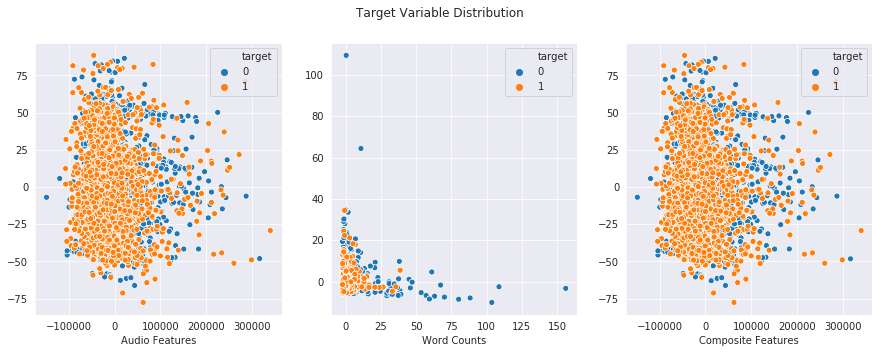

In [0]:
# reduce data to two dimensions
from sklearn.decomposition import PCA
Data_audio_2D = PCA(n_components=2).fit_transform(Data_audio)
Data_BoW_2D = PCA(n_components=2).fit_transform(Data_BoW)
Data_2D = PCA(n_components=2).fit_transform(Data)

labels_list = [target, target, target]
data_list = [ Data_audio_2D, Data_BoW_2D, Data_2D]
title_list = ["Audio Features", "Word Counts", "Composite Features", 
              "Target Variable Distribution"]
get_plots(labels_list, data_list, title_list)

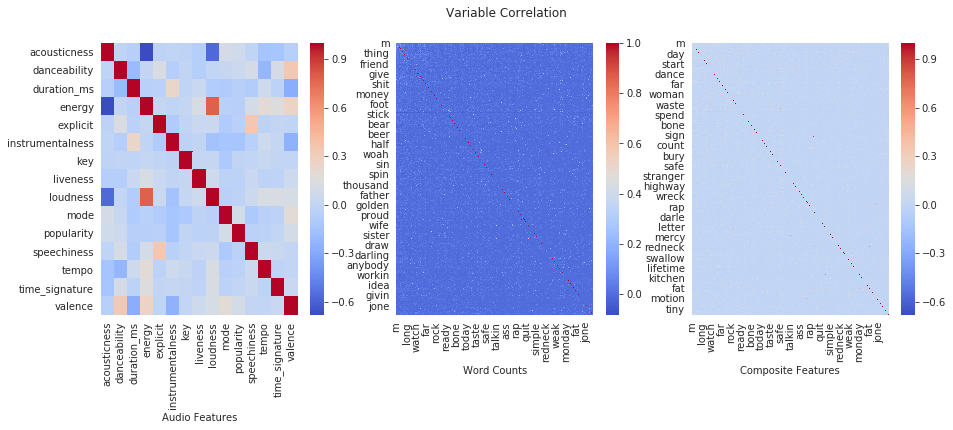

CPU times: user 19.2 s, sys: 1.32 s, total: 20.5 s
Wall time: 19 s


In [12]:
%%time
#plt.figure(figsize=(15,5))
#sns.heatmap(Data_BoW.corr(), cmap='coolwarm')
#plt.show();

num_plots = range(0,3)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(15,5))

data_list = [ Data_audio, Data_BoW, Data]
title_list = ["Audio Features", "Word Counts", "Composite Features", 
              "Feature Correlation"]

for n in num_plots:
  sns.heatmap(data_list[n].corr(), cmap='coolwarm', ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show();

### Scale Data

In [0]:
Data_audio.drop("explicit", axis=1, inplace=True)
Data.drop("explicit", axis=1, inplace=True)

Data_audio_raw = Data_audio.copy()
Data_BoW_raw = Data_BoW.copy()
Data_raw = Data.copy()

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

for d in [Data_audio, Data_BoW, Data]:
  d = scaler.fit_transform(d)
  d = pd.DataFrame(d)
  
Data_audio.columns = Data_audio_raw.columns
Data_audio["explicit"] = Audio_features["explicit"]
Data_BoW.columns = Data_BoW_raw.columns
Data.columns = Data_raw.columns
Data["explicit"] = Audio_features["explicit"]

## Clustering

### Model Feature Sets

In [0]:
def get_sil_plot(data, target, model, title="placeholder", n_max=10):
  """
  """
  #from sklearn.metrics import silhouette_score
  ground_truth = silhouette_score(data, target)

  sil_score = []
  n_range = list(range(2, n_max))
  for n in n_range:
    #model = model(n_clusters=n)
    labels = model(n_clusters=n).fit(data).labels_
    sil_score.append(silhouette_score(data, labels))

  sns.lineplot(n_range, sil_score, label="silhouette coefficient")
  sns.lineplot(n_range, ground_truth, label="ground truth")
  plt.xlabel("clusters")
  plt.ylabel("silhouette score")
  plt.title("{} Silhouette Plot".format(title))
  plt.legend()
  plt.show();

  n_optimal = n_range[sil_score.index(np.max(sil_score))]
  print("Optimal clusters: {}".format(n_optimal))
  return n_optimal

In [0]:
# define dataframes to store results
cluster_desc = []
cluster_score = pd.DataFrame()

# define supervised modeling function
def unsupervised_clf(model, data, target, test_size=0.25, stratify=True):
  """
  """
  #from sklearn.model_selection import train_test_split
  #from sklearn.metrics import adjusted_rand_score, make_scorer
  #from sklearn.model_selection import cross_val_score
  
  if stratify==True:
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=test_size, stratify=target)
  else:
    X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=test_size)
  
  #rand index
  # train/test
  labels = model.fit(X_train).labels_
  ARI_train = np.round(adjusted_rand_score(y_train, labels), 4)
  print("\nTraining Adjusted rand index: {}".format(ARI_train))
  labels = model.fit(X_test).labels_
  ARI_test = np.round(adjusted_rand_score(y_test, labels), 4)
  print("\nValidation Adjusted rand index: {}".format(ARI_train))
  # Cross validate
  model.fit(data)
  ARI_scores = cross_val_score(
      model, data, target, scoring=make_scorer(adjusted_rand_score), cv=5)
  ARI_var = np.round(np.var(ARI_scores)*100,4)
  ARI_CV = np.round(np.mean(ARI_scores),4)
  print("\nCV Adjusted rand index: {} +/- {}%".format(ARI_CV, ARI_var))
  
  vals = [ARI_train, ARI_test, ARI_CV, ARI_var]
  cols = ["ARI_train", "ARI_test", "ARI_CV", "ARI_var"]
  return pd.DataFrame([vals],
                      columns=cols)

### Audio Features

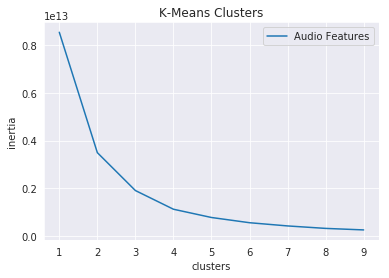

In [0]:
#from sklearn.cluster import KMeans
#from sklearn.cluster import MiniBatchKMeans

# Run the Kmeans algorithm and get the index of data points clusters
inertia_km = []
#inertia_mini = []
k_range = list(range(1, 10))

for k in k_range:
  #kmini = MiniBatchKMeans(n_clusters=k)
  kmeans = KMeans(n_clusters=k)
  inertia_km.append(kmeans.fit(Data_audio).inertia_)
  #inertia_mini.append(kmini.fit(Data).inertia_)

sns.lineplot(k_range, inertia_km, label="Audio Features")
#sns.lineplot(k_range, inertia_mini, label="Mini Batch")
plt.xlabel("clusters")
plt.ylabel("inertia")
plt.title("K-Means Clusters")
plt.legend()
plt.show;

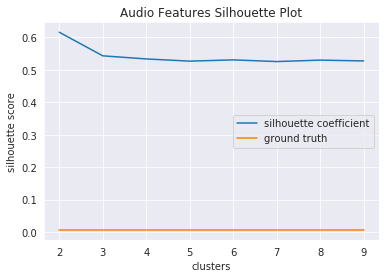

Optimal clusters: 2
Feature: audio

Training Adjusted rand index: 0.0001

Validation Adjusted rand index: 0.0001

CV Adjusted rand index: 0.0035 +/- 0.0019%


In [0]:
n_optimal = get_sil_plot(Data_audio, target, KMeans, title="Audio Features")

kmeans = KMeans(n_clusters=n_optimal)#, max_iter=600, algorithm ='auto')
#kmeans = MiniBatchKMeans(n_clusters=4)#, max_iter=600)#, algorithm ='auto')

cluster_desc.append("audio")

print("Feature: {}".format(cluster_desc[-1]))

new_score = unsupervised_clf(model=kmeans,
                             data=Data_audio,
                             target=target)
cluster_score = cluster_score.append(new_score, ignore_index=True)

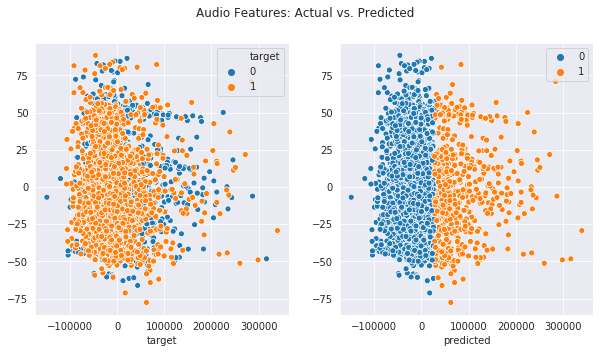

Actual
Class A: 48.5284%
Class B: 51.4716%

Predicted
Class A: 22.2408%
Class B: 77.75919999999999%



In [0]:
labels = kmeans.fit(Data_audio).labels_
#labels = kmeans.predict(Data_audio)
labels_list = [target, labels]
title_list=["target", "predicted", "Audio Features: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show();

target_dist = np.round(target.sum()/len(target)*100, 4)
predict_dist = np.round(labels.sum()/len(labels)*100, 4)

print("Actual\nClass A: {}%\nClass B: {}%\n".format(
    target_dist, 100-target_dist))
print("Predicted\nClass A: {}%\nClass B: {}%\n".format(
    predict_dist, 100-predict_dist))

### Lyric Features

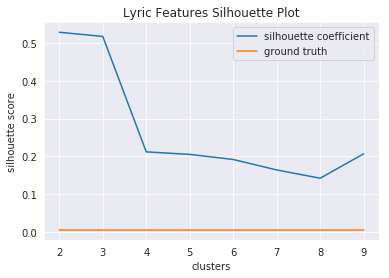

Optimal clusters: 2
Features: lyric

Training Adjusted rand index: -0.0008

Validation Adjusted rand index: -0.0008

CV Adjusted rand index: -0.0016 +/- 0.0004%


In [0]:
n_optimal = get_sil_plot(Data_BoW, target, KMeans, title="Lyric Features")

kmeans = KMeans(n_clusters=n_optimal)#, max_iter=600, algorithm ='auto')
#kmeans = MiniBatchKMeans(n_clusters=4)#, max_iter=600)#, algorithm ='auto')

cluster_desc.append("lyric")

print("Features: {}".format(cluster_desc[-1]))

new_score = unsupervised_clf(model=kmeans,
                             data=Data_BoW,
                             target=target)
cluster_score = cluster_score.append(new_score, ignore_index=True)

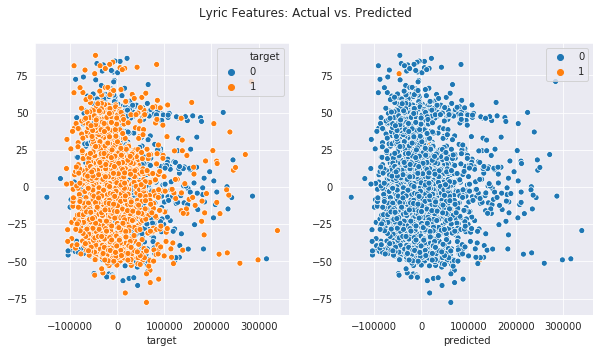

Actual
Class A: 48.5284%
Class B: 51.4716%

Predicted
Class A: 1.2709%
Class B: 98.7291%



In [0]:
labels = kmeans.fit(Data_BoW).labels_
#labels = kmeans.predict(Data_audio)
labels_list = [target, labels]
title_list=["target", "predicted", "Lyric Features: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show();

target_dist = np.round(target.sum()/len(target)*100, 4)
predict_dist = np.round(labels.sum()/len(labels)*100, 4)

print("Actual\nClass A: {}%\nClass B: {}%\n".format(
    target_dist, 100-target_dist))
print("Predicted\nClass A: {}%\nClass B: {}%\n".format(
    predict_dist, 100-predict_dist))

### All Features

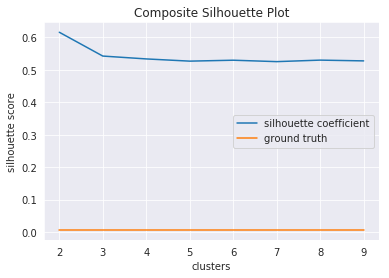

Optimal clusters: 2
Features: Composite

Training Adjusted rand index: -0.0003

Validation Adjusted rand index: -0.0003

CV Adjusted rand index: 0.0035 +/- 0.0019%


In [0]:
n_optimal = get_sil_plot(Data, target, KMeans, title="All Features")

kmeans = KMeans(n_clusters=n_optimal)#, max_iter=600, algorithm ='auto')
#kmeans = MiniBatchKMeans(n_clusters=4)#, max_iter=600)#, algorithm ='auto')

cluster_desc.append("Composite")

print("Features: {}".format(cluster_desc[-1]))

new_score = unsupervised_clf(model=kmeans,
                             data=Data,
                             target=target)
cluster_score = cluster_score.append(new_score, ignore_index=True)

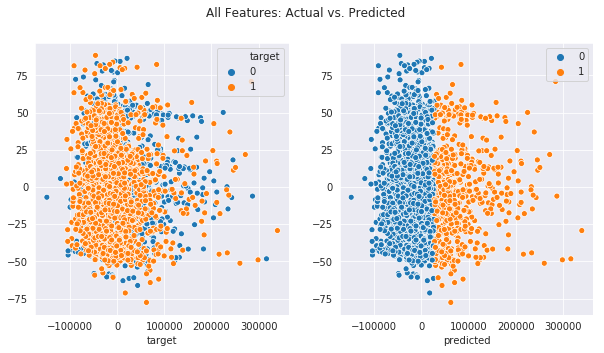

Actual
Class A: 48.5284%
Class B: 51.4716%

Predicted
Class A: 22.2408%
Class B: 77.75919999999999%



In [0]:
labels = kmeans.fit(Data).labels_
#labels = kmeans.predict(Data_audio)
labels_list = [target, labels]
title_list=["target", "predicted", "All Features: Actual vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show();

target_dist = np.round(target.sum()/len(target)*100, 4)
predict_dist = np.round(labels.sum()/len(labels)*100, 4)

print("Actual\nClass A: {}%\nClass B: {}%\n".format(
    target_dist, 100-target_dist))
print("Predicted\nClass A: {}%\nClass B: {}%\n".format(
    predict_dist, 100-predict_dist))

### Assessment

In [0]:
cluster_score.describe()

,ARI_train,ARI_test,ARI_CV,ARI_var
count,3.000000,3.000000,3.000000,3.000000
mean,-0.000333,-0.000667,0.001800,0.001400
std,0.000451,0.000503,0.002944,0.000866
min,-0.000800,-0.001200,-0.001600,0.000400
25%,-0.000550,-0.000900,0.000950,0.001150
50%,-0.000300,-0.000600,0.003500,0.001900
75%,-0.000100,-0.000400,0.003500,0.001900
max,0.000100,-0.000200,0.003500,0.001900


In [0]:
cluster_score = pd.concat([pd.Series(cluster_desc, name="model"), cluster_score], axis=1)
cluster_score.sort_values(by="ARI_CV", ascending=False).head(5)

,model,ARI_train,ARI_test,ARI_CV,ARI_var
0,audio,0.0001,-0.0006,0.0035,0.0019
2,Composite,-0.0003,-0.0012,0.0035,0.0019
1,lyric,-0.0008,-0.0002,-0.0016,0.0004


## Model Cluster Labels

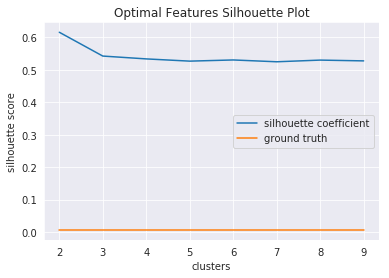

Optimal clusters: 2


In [0]:
# get labels
n_optimal = get_sil_plot(Data_audio, target, KMeans, title="Optimal Features")
kmeans = KMeans(n_clusters=n_optimal)
labels = kmeans.fit(Data_audio).labels_

In [0]:
# split data
#from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    Data_audio, labels, test_size=0.25, stratify=labels)

In [0]:
# fit model
# from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(learning_rate=.01)
model = model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print('\nTraining score:', train_score)
print('\nTest score:', test_score)

cv_scores = cross_val_score(model, Data, target, cv=5)
cv_score = np.round(np.mean(cv_scores)*100, 4)
variance = np.round(np.var(cv_scores)*100, 4)
print('\nCross validation: {} +/- {}%'.format(cv_score, variance))


Training score: 1.0

Test score: 1.0

Cross validation: 77.5921 +/- 0.2378%


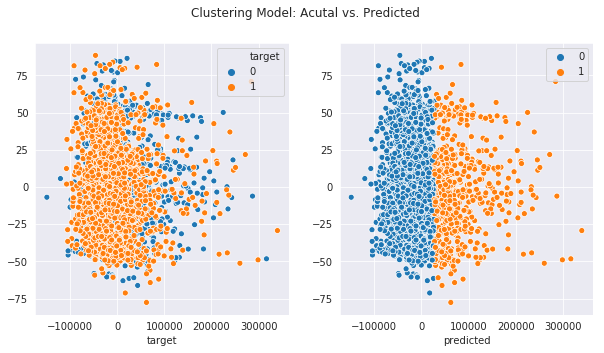

Labels
Class A: 48.5284%
Class B: 51.4716%

Predicted
Class A: 22.2408%
Class B: 77.75919999999999%



In [0]:
y_pred = model.predict(Data_audio)
labels_list = [target, y_pred]
title_list=["target", "predicted", "Clustering Model: Acutal vs. Predicted"]
data=Data_2D
num_plots = range(0,2)
  
# plot target variable
fig, axes = plt.subplots(1, len(num_plots), figsize=(10,5))

for n in num_plots:
  sns.scatterplot(data[:,0], data[:,1],
                  hue=labels_list[n], ax=axes[n])
  axes[n].set_xlabel(title_list[n])

fig.suptitle(title_list[-1])
plt.show();

target_dist = np.round(target.sum()/len(target)*100, 4)
predict_dist = np.round(y_pred.sum()/len(y_pred)*100, 4)

print("Labels\nClass A: {}%\nClass B: {}%\n".format(
    target_dist, 100-target_dist))
print("Predicted\nClass A: {}%\nClass B: {}%\n".format(
    predict_dist, 100-predict_dist))

In [0]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall: 20.744314266023434%
Precision: 50.53763440860215%


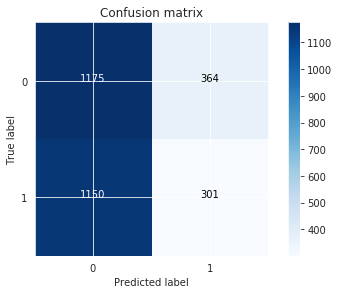

In [0]:
cnf_matrix = confusion_matrix(target, y_pred)

recall_metric = 100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall: {}%".format(recall_metric))

precision_metric = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision: {}%".format(precision_metric))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
#plt.savefig('.png')
plt.show()

ROC-AUC: 0.485


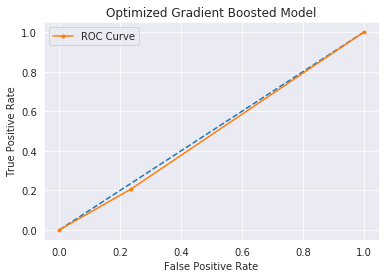

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

# calculate AUC
roc_auc = roc_auc_score(target, y_pred)
print('ROC-AUC: %.3f' % roc_auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(target, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Optimized Gradient Boosted Model')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
#plt.savefig('.png')
plt.show()

f1=0.284 auc=0.522 ap=0.479


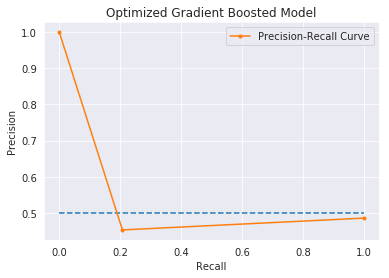

In [0]:
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.metrics import auc, average_precision_score

# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(target, y_pred)
# calculate F1 score
f1_score = f1_score(target, y_pred)
# calculate precision-recall AUC
precision_recall_auc = auc(recall, precision)
# calculate average precision score
avg_precision = average_precision_score(target, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1_score,
                                    precision_recall_auc,
                                    avg_precision))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Optimized Gradient Boosted Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
#plt.savefig('.png')
plt.show()

## Conclusion